<a href="https://colab.research.google.com/github/MiraInfern/ML/blob/main/Lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
!pip install pandas seaborn scikit-learn

# Домашнее задание 4

1. Преобразовать датасет (процессинг категориальных признаков, копия данных в df_not_processed, scale датасета)
2. Сделать k-means кластеризацию (записать cluster в df_not_processed, вывести статистику, графики. попробовать объяснить принцип кластеризации), оценить метриками, вывести результат
3. Подобрать оптимальное число кластеров с помощью "метод локтя", вывести статистику, графики, метрики, объяснить результат
4. Сделать DBSSCAN кластеризацию, подобрать оптимальные параметры, посчитать метрики, вывести статистику, объяснить результат
5. Ответить на вопрос - какой из методов кластеризации больше подходит для вашего датасета

In [25]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [26]:
EDUCATION_DATA_FILE = "/education_inequality_data.csv"
df = pd.read_csv(EDUCATION_DATA_FILE)
df_cluster = df.drop(columns=[
    'id', 'school_name', 'avg_test_score_percent',
    'is_score_high'
], errors='ignore').copy()

In [27]:
category_columns = df_cluster.select_dtypes(include=['object']).columns.tolist()
df_processed = pd.get_dummies(df_cluster, columns=category_columns, drop_first=True)
df_not_processed = df_processed.copy()
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_processed)
df_scaled = pd.DataFrame(df_scaled, columns=df_processed.columns)

### K-means Кластеризация

In [28]:
K = 3
kmeans_model = KMeans(n_clusters=K, random_state=42, n_init=10)
df_not_processed['cluster_kmeans_3'] = kmeans_model.fit_predict(df_scaled)
labels_kmeans_3 = df_not_processed['cluster_kmeans_3']


print(f"Распределение по кластерам:\n{labels_kmeans_3.value_counts()}")


silhouette_avg_3 = silhouette_score(df_scaled, labels_kmeans_3)
print(f"Средний коэффициент силуэта: {silhouette_avg_3:.4f}")

cluster_summary_3 = df_not_processed.groupby('cluster_kmeans_3').mean().T
print("\nСредние значения признаков по кластерам:")
print(cluster_summary_3)


Распределение по кластерам:
cluster_kmeans_3
0    593
1    288
2    119
Name: count, dtype: int64
Средний коэффициент силуэта: 0.0821

Средние значения признаков по кластерам:
cluster_kmeans_3                    0             1             2
funding_per_student_usd  15480.469224  14939.643056  14047.266639
student_teacher_ratio       19.964418     19.280556     19.676471
percent_low_income          52.570489     55.717361     54.920168
percent_minority            48.862732     51.213194     49.806723
internet_access_percent     75.531535     73.784028     72.676471
dropout_rate_percent         7.768044      7.573785      8.217647
state_Florida                0.124789      0.125000      0.000000
state_Georgia                0.126476      0.111111      0.000000
state_Illinois               0.116358      0.114583      0.000000
state_Michigan               0.101180      0.100694      0.000000
state_New York               0.096121      0.131944      0.000000
state_North Carolina         0.1

K-Means — это метод, который пытается разделить все данные на заранее заданное число групп (кластеров), которые вы сами указываете (это K)
Случайно выбирается центры для этих K групп (кластеров), потом просиходит распределение каждой точки данных в ту группу, центр которой находится к ней ближе всего. Затем уже пересчитывается центр каждой группы (находится среднее арифметическое всех точек в ней) и повторяются шаги 2 и 3, пока центры групп не перестанут сильно сдвигаться.
Главная цель же, этл сделать так, чтобы точки внутри одной группы были максимально похожи друг на друга.

### Метод локтя

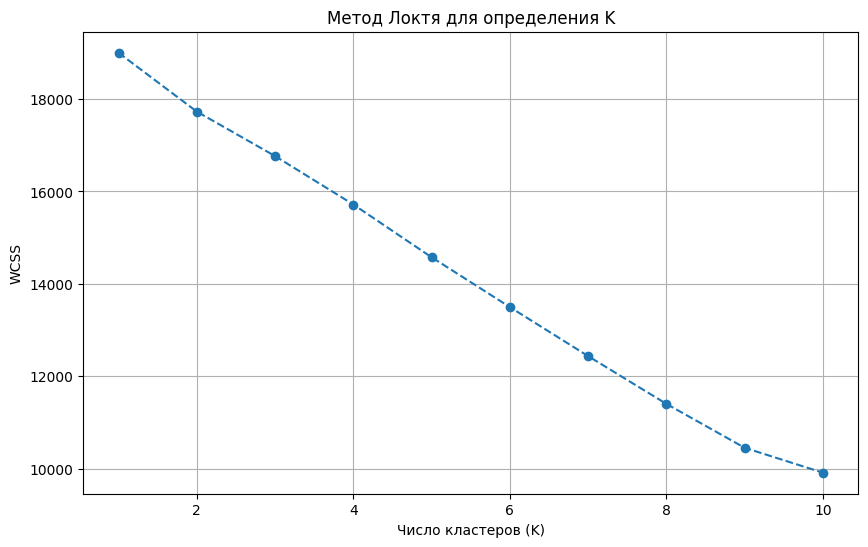

Результаты K-Means с K=4
Средний коэффициент силуэта: 0.1265


In [31]:
wcss = []
K_range = range(1, 11)

for k in K_range:
    kmeans_k = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_k.fit(df_scaled)
    wcss.append(kmeans_k.inertia_)
plt.figure(figsize=(10, 6))
plt.plot(K_range, wcss, marker='o', linestyle='--')
plt.title('Метод Локтя для определения K')
plt.xlabel('Число кластеров (K)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

K_opt = 4
kmeans_opt = KMeans(n_clusters=K_opt, random_state=42, n_init=10)
df_not_processed['cluster_kmeans_opt'] = kmeans_opt.fit_predict(df_scaled)

silhouette_opt = silhouette_score(df_scaled, df_not_processed['cluster_kmeans_opt'])
print(f"Результаты K-Means с K={K_opt}")
print(f"Средний коэффициент силуэта: {silhouette_opt:.4f}")

Метод Локтя помогает найти лучшее число групп K для K-Means, чтобы группы были максимально компактными и при этом их было не слишком много. Он работает, строя график, который показывает, насколько компактны все группы вместе взятые, при разном количестве K. Оптимальное K - это точка на графике, где линия резко перестает падать (похоже на локоть), потому что дальнейшее увеличение K дает уже минимальное улучшение качества.

### DBSCAN Кластеризация

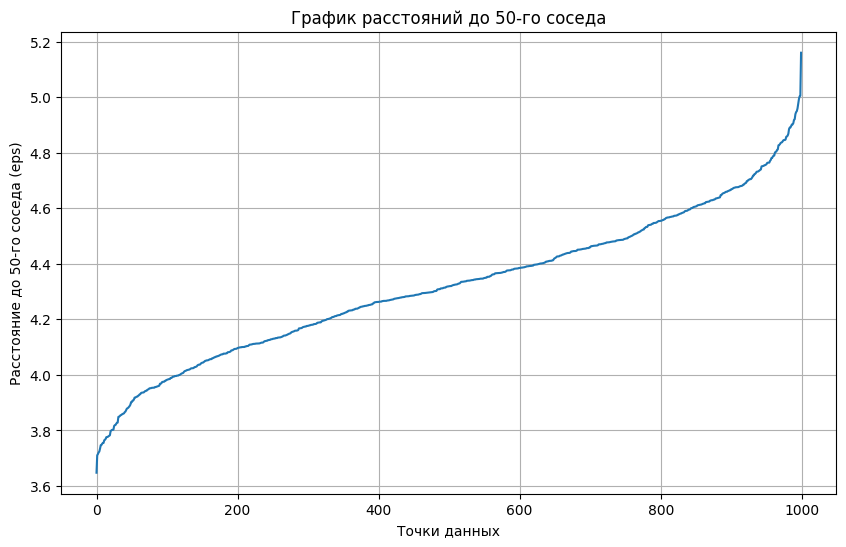

Результаты DBSCAN (eps=3.5, min_samples=5)
Распределение по кластерам (Кластер -1 это шум):
cluster_dbscan
 2    731
 1     95
 0     89
 3     84
-1      1
Name: count, dtype: int64
Число кластеров (без шума): 4
Средний коэффициент силуэта (без шума): 0.1356


In [32]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

k_neighbors = 50
neigh = NearestNeighbors(n_neighbors=k_neighbors)

neigh.fit(df_scaled)
distances, indices = neigh.kneighbors(df_scaled)


distances = np.sort(distances[:, k_neighbors-1], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title(f'График расстояний до {k_neighbors}-го соседа')
plt.xlabel('Точки данных')
plt.ylabel(f'Расстояние до {k_neighbors}-го соседа (eps)')
plt.grid(True)
plt.show()


epsilon = 3.5
min_samples = 5

dbscan_model = DBSCAN(eps=epsilon, min_samples=min_samples)
labels_dbscan = dbscan_model.fit_predict(df_scaled)
df_not_processed['cluster_dbscan'] = labels_dbscan

print(f"Результаты DBSCAN (eps={epsilon}, min_samples={min_samples})")
print(f"Распределение по кластерам (Кластер -1 это шум):\n{df_not_processed['cluster_dbscan'].value_counts()}")
num_clusters = len(np.unique(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
print(f"Число кластеров (без шума): {num_clusters}")

if num_clusters > 0 and len(labels_dbscan[labels_dbscan != -1]) > 0:
    core_samples_mask = (labels_dbscan != -1)
    silhouette_dbscan = silhouette_score(df_scaled[core_samples_mask], labels_dbscan[core_samples_mask])
    print(f"Средний коэффициент силуэта (без шума): {silhouette_dbscan:.4f}")
else:
    print("Невозможно рассчитать силуэт (только шум или менее двух кластеров).")


DBSCAN (Density-Based Spatial Clustering of Applications with Noise) - это метод, который ищет группы, основываясь на плотности данных, а не на их центрах. Он объединяет точки, если они расположены достаточно близко друг к другу (в пределах заданного радиуса ), и если в этом радиусе есть достаточно соседей. Главное отличие: DBSCAN может находить группы любой формы и автоматически помечает одинокие точки, не входящие ни в одну плотную область, как шум (выбросы).

Для нашего датасета K-Means является более подходящим методом для первичного анализа и структурированной сегментации. Выбран был он, потому что наша цель - сегментировать данные на заранее заданное число типовых групп (кластеров), что K-Means выполняет эффективно, гарантируя нахождение K групп с центроидами, которые легко описать.

Несмотря на то, что DBSCAN способен находить кластеры произвольной формы и выявлять аномалии, его результаты очень чувствительны к выбору параметров и он не гарантирует создания четко структурированных, равных по "важности" кластеров, которые удобны для дальнейшего сравнения и анализа типов школ и т.д.